Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable = ["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Downloading the dataset

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K' -O dataset

--2021-11-03 17:23:52--  https://docs.google.com/uc?export=download&id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
Resolving docs.google.com (docs.google.com)... 108.177.97.113, 108.177.97.139, 108.177.97.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mrernl16i3o8kueireava9902sp177pm/1635960225000/10915318309229425367/*/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K?e=download [following]
--2021-11-03 17:23:53--  https://doc-14-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mrernl16i3o8kueireava9902sp177pm/1635960225000/10915318309229425367/*/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K?e=download
Resolving doc-14-2k-docs.googleusercontent.com (doc-14-2k-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to doc-14-2k-docs.googleusercontent.com (doc-14-2k-d

### Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
with open("/content/dataset") as fin : 
  data = json.load(fin) # returns JSON object as a dictionary

df = pd.json_normalize(data)

### Understanding the data and cleaning it

In [4]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.sample(5)

(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
22427,complaint-public-v2,complaint,3222510,0.0,None,802XX,3222510,Problem with a credit reporting company's inve...,2019-04-25T12:00:00-05:00,CO,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-25T12:00:00-05:00,None,Credit reporting,Yes,Chase Card partial account number XXXX***** - ...,Their investigation did not fix an error on yo...,Consent provided
32169,complaint-public-v2,complaint,2688602,0.0,None,19406,2688602,Incorrect information on your report,2017-09-30T12:00:00-05:00,PA,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-30T12:00:00-05:00,None,Credit reporting,Yes,,Account information incorrect,Consent not provided
69290,complaint-public-v2,complaint,1369253,0.0,None,07875,1369253,"Loan modification,collection,foreclosure",2015-05-11T12:00:00-05:00,NJ,Yes,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2015-05-13T12:00:00-05:00,None,Other mortgage,Yes,,None,N/A
43575,complaint-public-v2,complaint,2676930,0.0,None,981XX,2676930,Managing an account,2017-09-17T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2017-10-14T12:00:00-05:00,None,Other banking product or service,Yes,,Funds not handled or disbursed as instructed,N/A
29402,complaint-public-v2,complaint,1716083,0.0,None,891XX,1716083,Deposits and withdrawals,2015-12-24T12:00:00-05:00,NV,Yes,Bank account or service,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-12-24T12:00:00-05:00,None,Other bank product/service,Yes,I believe Chase bank is in violation of the le...,None,Consent provided


In [5]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


Changing column names to make them more understandable

In [6]:
df.columns = [re.sub("^_(source.)?", "", column_name) for column_name in df.columns]
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


Replace all the blanks with nan in the complaints columns and remove all rows of the dataframe containing nan in the complaints column

In [7]:
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x : np.nan if re.search("^[\s]*$", x) else x)
df = df[~(df["complaint_what_happened"].isnull())]
df.shape

(21072, 22)

### Prepare the text for topic modeling



Defining a function to clean the text - convert the text to lower case, remove text in square brackets, remove punctuation, remove words containing numbers

In [10]:
def cleaner(complaint) :
  complaint = complaint.lower()
  complaint = re.sub("\[.*?\]", "", complaint)
  complaint = "".join([char for char in complaint if char not in string.punctuation])
  complaint = re.sub("[^\s]*[\d]+[^\s]*", "", complaint)
  return complaint

complaints = df["complaint_what_happened"].apply(cleaner)

Defining a function that lemmatizes the text and extracts only NOUNS

In [12]:
def lemmatizer_posfilter(complaint) :
  doc = nlp(str(complaint))
  lemma_complaint = " ".join([token.lemma_ for token in doc])
  pos_filtered = " ".join([token.lemma_ for token in doc if token.pos_ == "NOUN"])
  return lemma_complaint, pos_filtered

lemma_pos = complaints.apply(lemmatizer_posfilter)
lemmatized_complaints = [lemma_complaint for lemma_complaint, pos_filtered_complaint in lemma_pos]
pos_filtered_complaints = [pos_filtered_complaint for lemma_complaint, pos_filtered_complaint in lemma_pos]

Creating a dataframe "df_clean" that holds the raw_complaints, initial_preprocessed_complaints, lemmatized_complaints and the pos_filtered_complaints

In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
pd.set_option("max_colwidth", None)
df_clean = pd.DataFrame({"raw_complaints" : df["complaint_what_happened"], "initial_preprocessed_complaints" : complaints, "lemmatized_complaints" : lemmatized_complaints, "pos_filtered_complaints" : pos_filtered_complaints})
df_clean.reset_index(drop = True, inplace = True)
df_clean.sample(3)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints
11956,"Sold vehicle I had financed with Chase Bank. I owed {$25000.00} and sold vehicle for {$30000.00}. Buyer sent check ( was told it was a cashiers check ) directly to Chase bank. Check was rec 'd at Chase on XX/XX/20. I contacted Chase on XX/XX/20 and was told loan was paid in full. I specifically asked if it was okay in releasing vehicle to buyer. I was told yes, it was a recorded line so this should be verifiable. I was told it would take approximately 10 days for the additional funds to reach me. On XX/XX/20 buyer provided sent me a proof of insurance on vehicle and arranged for a local towing company to pick up the vehicle. On XX/XX/20 I reached out to Chase Bank again on status of check that was to come to me and was told the check had been mailed out. On XX/XX/20 Chase mailed me the vehicle lien release. On XX/XX/20 after still not receiving the check I reached out to Chase who advised the check mailed to me certified check and been intercepted because the buyers check had a stop payment placed on it on XX/XX/20 and therefore the loan was reinstated. At this point the truck is no longer in my position and Chase has been completely unwilling to help and continue to state my next payment is due on XX/XX/XXXX. I've spoke with their fraud department who said it was a said situation, but there was nothing they could do. I've asked Chase for a copy of the check and they said they would mail it to me, but haven't gotten it. I do not understand how Chase can accept a check on XX/XX/20 and it allowed to be stopped XX/XX/20. Of course the buyer 's number is no longer in service, the police has went to the location that the truck was delivered and it isn't there, the address the buyer gave it to an office building. I felt having the check mailed directly to Chase and waiting for them to advise us when it was safe to release possession of the truck was being extra cautious and they are blaming us for the issue and told us just to turn it in to our insurance. This will cause our rates to go up and be possibly dropped.",sold vehicle i had financed with chase bank i owed and sold vehicle for buyer sent check was told it was a cashiers check directly to chase bank check was rec d at chase on i contacted chase on and was told loan was paid in full i specifically asked if it was okay in releasing vehicle to buyer i was told yes it was a recorded line so this should be verifiable i was told it would take approximately days for the additional funds to reach me on buyer provided sent me a proof of insurance on vehicle and arranged for a local towing company to pick up the vehicle on i reached out to chase bank again on status of check that was to come to me and was told the check had been mailed out on chase mailed me the vehicle lien release on after still not receiving the check i reached out to chase who advised the check mailed to me certified check and been intercepted because the buyers check had a stop payment placed on it on and therefore the loan was reinstated at this point the truck is no longer in my position and chase has been completely unwilling to help and continue to state my next payment is due on xxxxxxxx ive spoke with their fraud department who said it was a said situation but there was nothing they could do ive asked chase for a copy of the check and they said they would mail it to me but havent gotten it i do not understand how chase can accept a check on and it allowed to be stopped of course the buyer s number is no longer in service the police has went to the location that the truck was delivered and it isnt there the address the buyer gave it to an office building i felt having the check mailed directly to chase and waiting for them to advise us when it was safe to release possession of the truck was being extra cautious and they are blaming us for the issue and told us just to turn it in to our insurance this will cau

### Exploratory data analysis to get familiar with the data.





Visualising data according to the complaint's character length

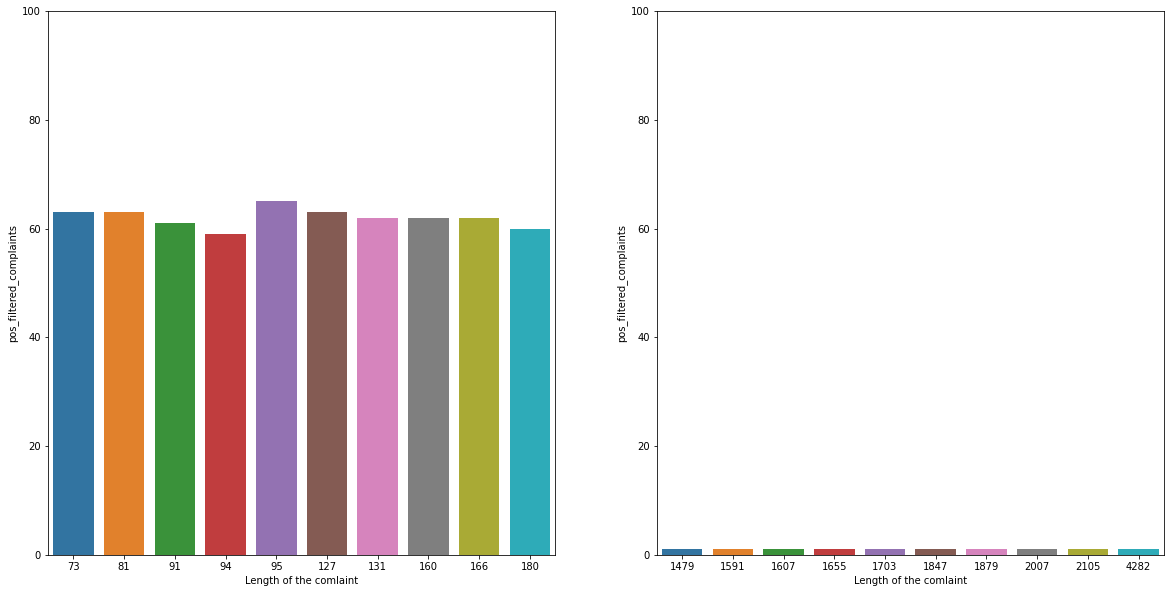

In [14]:
len_complaints = df_clean["pos_filtered_complaints"].apply(len).value_counts()
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.ylim((0, 100))
plt.xlabel("Length of the comlaint")
plt.ylabel("No of complaints")
sns.barplot(x = len_complaints.index[:10], y = len_complaints[:10])
plt.subplot(1, 2, 2)
plt.ylim((0, 100))
plt.xlabel("Length of the comlaint")
plt.ylabel("No of complaints")
sns.barplot(x = len_complaints.index[-10:], y = len_complaints[-10:])
plt.show()



*   Most of the complaints have a length in the range 50-200
*   There are very few complaints having lengths greater than 1000



Find the top 40 words by frequency among all the articles after processing the text.

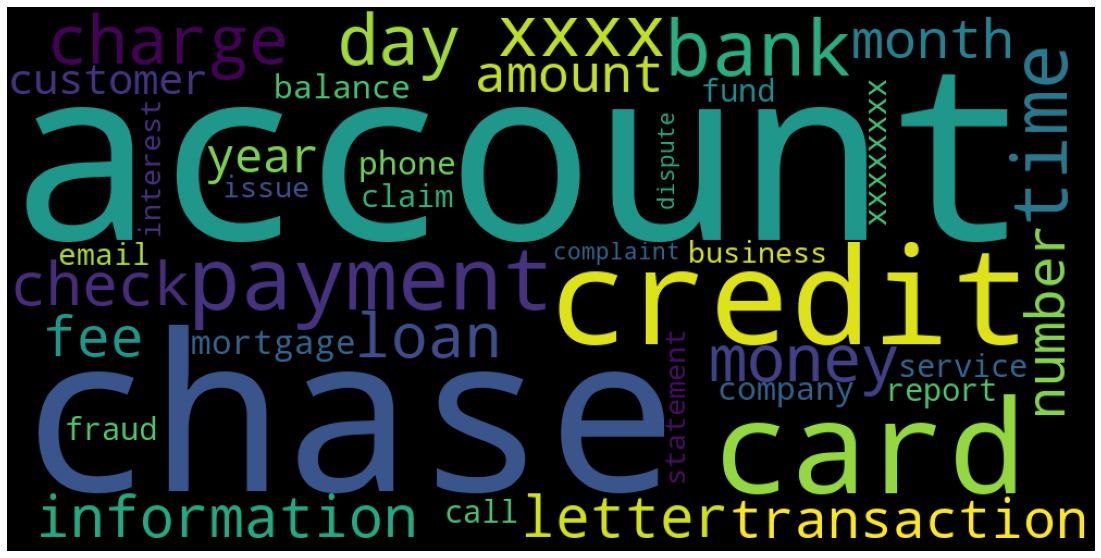

In [15]:
#Using a word cloud to find the top 40 words by frequency among all the articles after processing the text
word_cloud = WordCloud(collocations = False, width = 1000, height = 500, max_words = 40, random_state = 100).generate(" ".join(df_clean["pos_filtered_complaints"]))
plt.figure(figsize = (20, 10))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()



*   Words like transaction, credit, payment, account are highly frequent in the text corpus
*   Since chase is the company's name, it also has a high frequency of occurrence in the text corpus



All personal details of customers have been marked as xx...
Such masks are removed since they don't carry any information. The word "chase" has also been removed because it is the name of the company that is appearing in most of the complaints and doesn't carry any information

In [17]:
def xx_removal(complaint) :
  if re.search(r"\b[^\s]*x{2,}\b", complaint) :
    complaint = re.sub(r"\b[^\s]*x{2,}\b", "", complaint)
  if re.search(r"\bchase\b", complaint) :
    complaint = re.sub(r"\bchase\b", "", complaint)
  return complaint

df_clean["final_preprocessed_complaints"] = df_clean["pos_filtered_complaints"].apply(xx_removal)

In [18]:
df_clean.sample(5)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints
10798,"On XXXX XXXX 2017 , I noticed that an Amazon Chase Visa ha d been added to my husband 's and mine account. I found this out as I was checking the balance of a credit card we have had for years with Chase ( XXXX Visa ) - a nd all of a sudden, there were XXXX accounts instead of just XXXX . We had never applied for this card and called XXXX immediatel y. Someone had fraudulently opened the Amazon Chase Visa card in our name on the exact same da y ( XXXX XXXX ). Chase cancelled the card.\n<P/>\nChase was helpful in cancelling the card, but when asked if they would contact the credit bureaus, we were told that was our problem. They opened a card without any information other than an old address ( from more than three years ago ) and an obviously fake email address, but we now have to fix the problem? <P/> In addition, based on internet research, this appears to potentially be a n inside job either by Amazon or Chase.\n<P/> I have put fraud alerts on both my husband 's and my credit reports with all the credit bureaus.",on xxxx xxxx i noticed that an amazon chase visa ha d been added to my husband s and mine account i found this out as i was checking the balance of a credit card we have had for years with chase xxxx visa a nd all of a sudden there were xxxx accounts instead of just xxxx we had never applied for this card and called xxxx immediatel y someone had fraudulently opened the amazon chase visa card in our name on the exact same da y xxxx xxxx chase cancelled the card\np\nchase was helpful in cancelling the card but when asked if they would contact the credit bureaus we were told that was our problem they opened a card without any information other than an old address from more than three years ago and an obviously fake email address but we now have to fix the problem p in addition based on internet research this appears to potentially be a n inside job either by amazon or chase\np i have put fraud alerts on both my husband s and my credit reports with all the credit bureaus,on xxxx xxxx i notice that an amazon chase visa ha d be add to -PRON- husband s and mine account i find this out as i be check the balance of a credit card -PRON- have have for year with chase xxxx visa a nd all of a sudden there be xxxx account instead of just xxxx -PRON- have never apply for this card and call xxxx immediatel y someone have fraudulently open the amazon chase visa card in -PRON- name on the exact same da y xxxx xxxx chase cancel the card \n p \n chase be helpful in cancel the card but when ask if -PRON- would contact the credit bureaus -PRON- be tell that be -PRON- problem -PRON- open a card without any information other than an old address from more than three year ago and an obviously fake email address but -PRON- now have to fix the problem p in addition base on internet research this appear to potentially be a n inside job either by amazon or chase \n p i have put fraud alert on both -PRON- husband s and -PRON- credit report with all the credit bureaus,husband s mine account balance credit card year xxxx account xxxx card card name chase card chase card credit bureaus problem card information address year email address problem p addition internet research job fraud alert husband s credit report credit bureaus,husband s mine account balance credit card year account card card name card card credit bureaus problem card information address year email address problem p addition internet research job fraud alert husband s credit report credit bureaus
6899,I do not know these inquiries that appears on my report. I need to get something done and these inquiries that I do not hinders me for doing so. I researched about on how to deal with them and the best result is seeking help through you guys. All I need to get this them removed. I know this is a violation of credit reporting under FCRA.,i do not know these i

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
# Finding the top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean)
count_vect = CountVectorizer(stop_words = "english", max_features = 5000)
count_matrix = count_vect.fit_transform(df_clean["final_preprocessed_complaints"])
idx = count_matrix.toarray().sum(axis = 0).argsort()[::-1][:30]
unigram_freq = pd.DataFrame(count_matrix.toarray().sum(axis = 0)[idx].reshape(1, -1), columns = np.array(count_vect.get_feature_names())[idx])
unigram_freq

,account,credit,card,payment,bank,time,day,charge,money,loan,check,information,letter,fee,transaction,number,month,year,customer,mortgage,balance,phone,company,service,fund,report,fraud,claim,email,business
0,47027,32175,30299,21086,16234,16003,12941,12114,11953,10693,10379,9641,9541,8811,8602,8594,8459,8289,8131,8043,7733,7561,7507,7215,7026,6916,6774,6509,5870,5474


In [20]:
#Print the top 10 words in the unigram frequency
unigram_freq.iloc[0, :10].index

Index(['account', 'credit', 'card', 'payment', 'bank', 'time', 'day', 'charge',
       'money', 'loan'],
      dtype='object')

In [21]:
#Finding the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
count_vect = CountVectorizer(stop_words = "english", ngram_range = (2, 2), max_features = 5000)
count_matrix = count_vect.fit_transform(df_clean["final_preprocessed_complaints"])
idx = count_matrix.toarray().sum(axis = 0).argsort()[::-1][:30]
bigram_freq = pd.DataFrame(count_matrix.toarray().sum(axis = 0)[idx].reshape(1, -1), columns = np.array(count_vect.get_feature_names())[idx])
bigram_freq

,credit card,credit report,account account,customer service,checking account,bank account,card account,payment payment,debit card,account credit,credit score,card card,money account,card credit,phone number,account number,business day,charge account,card company,fund account,account bank,payment account,mortgage payment,account balance,saving account,account money,account payment,loan modification,police report,credit reporting
0,12666,3831,3392,2895,2242,2241,1901,1875,1868,1809,1715,1606,1566,1441,1275,1241,1236,1184,1151,1142,1132,1128,1093,1070,1050,1033,1021,985,974,970


In [22]:
#Print the top 10 words in the bigram frequency
bigram_freq.iloc[0, :10].index

Index(['credit card', 'credit report', 'account account', 'customer service',
       'checking account', 'bank account', 'card account', 'payment payment',
       'debit card', 'account credit'],
      dtype='object')

In [23]:
#Finding the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
count_vect = CountVectorizer(stop_words = "english", ngram_range = (3, 3), max_features = 5000)
count_matrix = count_vect.fit_transform(df_clean["final_preprocessed_complaints"])
idx = count_matrix.toarray().sum(axis = 0).argsort()[::-1][:30]
trigram_freq = pd.DataFrame(count_matrix.toarray().sum(axis = 0)[idx].reshape(1, -1), columns = np.array(count_vect.get_feature_names())[idx])
trigram_freq

,credit card account,credit card company,credit card credit,card credit card,account credit card,inquiry credit report,charge credit card,credit report credit,credit card card,credit reporting agency,credit card payment,account credit report,customer service representative,account account account,credit reporting act,payment credit card,credit card charge,payment payment payment,credit card balance,checking saving account,victim identity theft,credit card year,credit card statement,credit card service,account money account,freedom credit card,credit card number,credit report account,account debit card,account customer service
0,1095,984,730,631,572,562,495,414,391,383,367,367,327,318,314,303,297,296,293,259,252,235,230,220,216,209,200,198,189,188


In [24]:
#Print the top 10 words in the trigram frequency
trigram_freq.iloc[0, :10].index

Index(['credit card account', 'credit card company', 'credit card credit',
       'card credit card', 'account credit card', 'inquiry credit report',
       'charge credit card', 'credit report credit', 'credit card card',
       'credit reporting agency'],
      dtype='object')

### Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

In [25]:
# Initialising the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = "english", ngram_range = (1, 3), max_features = 10000)

In [26]:
#Creating a document term matrix
document_term = vectorizer.fit_transform(df_clean["final_preprocessed_complaints"])

In [27]:
vocab = np.array(vectorizer.get_feature_names())
print("Vocabulary size :",len(vocab))

10000


## Topic Modelling using NMF


In [28]:
from sklearn.decomposition import NMF

Choosing the number of topics as 3 and building an NMF model on the document_term matrix

In [29]:
num_topics = 3
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words



*  Topic 3 seems to be a valid topic
*  Topic 1 and 2 appear to be containing sub topics



Choosing the no of topics as 4 and repeating the process

In [32]:
num_topics = 4
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
                                
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,transaction,day,branch,deposit,account account,claim,fee,number,checking,fraud
Topic 2,card,credit,credit card,charge,dispute,balance,purchase,company,card card,service,time,card credit,merchant,fee,fraud
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,mortgage payment,letter,house,document
Topic 4,credit,report,inquiry,credit report,inquiry credit,inquiry credit report,account,score,debt,report credit,information,reporting,account credit,credit report credit,credit score




*   Topic 3 and 4 seem to be valid topics
*   Topic 1 and 2 seem to contain sub topics





Choosing the number of toics as 5 and repeating the process

In [33]:
num_topics = 5
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
                                
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,branch,deposit,account account,day,fee,checking,bank account,checking account,transaction,business
Topic 2,card,credit,credit card,balance,card credit,card card,account,card account,fee,score,limit,credit card account,year,credit card credit,payment
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,mortgage payment,house,loan modification,letter
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,information,report credit,debt,reporting,credit report credit,identity,account,company,account credit
Topic 5,charge,dispute,transaction,merchant,claim,fraud,email,company,card,letter,service,time,purchase,information,phone





*   All are valid topics




Lets see if more topics can be extracted. 
Choosing the number of topics as 6 and repeating the process

In [34]:
num_topics = 6
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,money,bank,account account,fund,fee,branch,checking,transaction,deposit,checking account,day,bank account,transfer,balance
Topic 2,card,credit,credit card,balance,card credit,card card,card account,score,limit,credit card credit,year,credit card account,fee,month,point
Topic 3,payment,loan,mortgage,modification,home,month,year,time,payment payment,property,rate,mortgage payment,house,loan modification,foreclosure
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,information,report credit,reporting,debt,credit report credit,company,identity,score,report inquiry
Topic 5,charge,dispute,transaction,merchant,claim,fraud,email,company,time,service,card,letter,phone,purchase,information
Topic 6,check,bank,fund,check check,money,check account,deposit,account check,day,check bank,branch,bank check,hold,cashier,business




*   Topic 6 is a repeated topic



In [35]:
num_topics = 7
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,money,bank,account account,fund,branch,checking,transaction,deposit,fee,checking account,bank account,number,day,transfer
Topic 2,card,credit,credit card,card credit,card card,balance,card account,score,credit card credit,limit,year,credit card account,point,card company,card credit card
Topic 3,loan,mortgage,home,modification,property,year,rate,document,loan modification,time,foreclosure,sale,house,letter,debt
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,report credit,information,reporting,credit report credit,debt,company,identity,score,report inquiry
Topic 5,charge,dispute,transaction,merchant,claim,fraud,email,service,company,purchase,card,time,day,charge charge,phone
Topic 6,check,bank,fund,check check,check account,money,deposit,account check,day,check bank,branch,bank check,hold,cashier,business
Topic 7,payment,payment payment,balance,fee,month,statement,payment account,account payment,payment credit,time,payment month,day,payment time,date,month payment




*   Topic 6 and 7 are repeated topics



Only 5 topics can be extracted from this dataset

In [36]:
num_topics = 5
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
                                
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,branch,deposit,account account,day,fee,checking,bank account,checking account,transaction,business
Topic 2,card,credit,credit card,balance,card credit,card card,account,card account,fee,score,limit,credit card account,year,credit card credit,payment
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,mortgage payment,house,loan modification,letter
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,information,report credit,debt,reporting,credit report credit,identity,account,company,account credit
Topic 5,charge,dispute,transaction,merchant,claim,fraud,email,company,card,letter,service,time,purchase,information,phone


Extracting the dominant topic from each complaint and assigning them an integer value (0, 1, 2, 3, 4)

In [37]:
document_topic = pd.DataFrame(W, columns = [f'Topic {i + 1}' for i in range(num_topics)])
document_topic["Dominant_Topic"] = document_topic.apply(lambda x : np.argmax(x), axis = 1)
document_topic.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Dominant_Topic
0,0.015441,0.001768,0.011812,0.010910,0.008149,0
1,0.007532,0.012539,0.003557,0.001112,0.009220,1
2,0.000000,0.035871,0.000000,0.020065,0.003474,1
3,0.011775,0.025684,0.002642,0.053596,0.005497,3
4,0.051807,0.000000,0.000000,0.000000,0.001687,0


In [38]:
df_clean['Topic'] = document_topic["Dominant_Topic"]
df_clean.sample(5)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints,Topic
19993,"I am an attorney in New Jersey. I sold a home and the proceeds were wired into my Attorney Trust Account on XX/XX/18. Once the wire posted, I wrote a check from my attorney trust account to myself and went to my local Chase branch to deposit it into my personal account. The teller told me it would be a 2 day hold. I said "" Fine '' and deposited the check. On the day the hold was to be released, I get an email from Chase saying that they were going to hold it an additional 8 days. I went to the Chase branch who then had to call me back once the manager returned. Manager said she could not do anything. I asked to give me the check back, but they said that they could not do that. They escalated the problem to their corporate help line, but they said that they would not clear it nor give me my check back. The only reason for the hold was that the check amount was large. As a lawyer, if I bounce an trust account check, I would lose my law license and go to jail. \nI have completed thousands of real estate closings and never had a proceeds check held for a week and a half. If that was to be the case, I would have wired the money. I believe that they are only holding the check to take advantage of using the interest free money for 10 days.",i am an attorney in new jersey i sold a home and the proceeds were wired into my attorney trust account on once the wire posted i wrote a check from my attorney trust account to myself and went to my local chase branch to deposit it into my personal account the teller told me it would be a day hold i said fine and deposited the check on the day the hold was to be released i get an email from chase saying that they were going to hold it an additional days i went to the chase branch who then had to call me back once the manager returned manager said she could not do anything i asked to give me the check back but they said that they could not do that they escalated the problem to their corporate help line but they said that they would not clear it nor give me my check back the only reason for the hold was that the check amount was large as a lawyer if i bounce an trust account check i would lose my law license and go to jail \ni have completed thousands of real estate closings and never had a proceeds check held for a week and a half if that was to be the case i would have wired the money i believe that they are only holding the check to take advantage of using the interest free money for days,i be an attorney in new jersey i sell a home and the proceed be wire into -PRON- attorney trust account on once the wire post i write a check from -PRON- attorney trust account to -PRON- and go to -PRON- local chase branch to deposit -PRON- into -PRON- personal account the teller tell -PRON- -PRON- would be a day hold i say fine and deposit the check on the day the hold be to be release i get an email from chase say that -PRON- be go to hold -PRON- an additional day i go to the chase branch who then have to call -PRON- back once the manager return manager say -PRON- could not do anything i ask to give -PRON- the check back but -PRON- say that -PRON- could not do that -PRON- escalate the problem to -PRON- corporate help line but -PRON- say that -PRON- would not clear -PRON- nor give -PRON- -PRON- check back the only reason for the hold be that the check amount be large as a lawyer if i bounce an trust account check i would lose -PRON- law license and go to jail \n i have complete thousand of real estate closing and never have a proceed check hold for a week and a half if that be to be the case i would have wire the money i believe that -PRON- be only hold the check to take advantage of use the interest free money for day,attorney home proceed attorney trust account wire check attorney trust account chase branch account teller day hold check day hold email day branch manager ma

Validate the documnet topic mapping

In [39]:
#Print the first 5 Complaint for each of the Topics  
df_clean.groupby('Topic').head(5).sort_values(by = "Topic")

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer account thank advance help,0
10,mishandling of this account by Chase auto and XXXX.,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,account,account,0
6,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account look

Assigning appropriate labels to topics

In [40]:
topic_idx_name_mapping = {0 : "Bank Account services", 1 : "Credit card/Prepaid card", 2 : "Mortgage/Loan", 3 : "Others", 4 : "Theft/Dispute Reporting"}
df_clean['Topic'] = df_clean['Topic'].map(topic_idx_name_mapping)
df_clean.sample(5)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints,Topic
12363,"Chase Freedom Visa is changing the terms of my agreement including what constitutes a "" cash like '' transaction. I would like to prevent the card from being able to make a "" cash like '' transaction, but they informed me it is not possible to do. I then asked to reduce the cash advance limit to XXXX $ and they also informed that is not possible to do. My XXXX XXXX Visa has no problem setting the limit to XXXX . By not honoring my request, Chase is forcing me to cancel the Chase card and obtain a new card from another financial company, which will have a negative impact on my Credit Rating. The Federal Government should regulate Credit Card companies to force them to provide a means to disable unwanted ( features and fees ).",chase freedom visa is changing the terms of my agreement including what constitutes a cash like transaction i would like to prevent the card from being able to make a cash like transaction but they informed me it is not possible to do i then asked to reduce the cash advance limit to xxxx and they also informed that is not possible to do my xxxx xxxx visa has no problem setting the limit to xxxx by not honoring my request chase is forcing me to cancel the chase card and obtain a new card from another financial company which will have a negative impact on my credit rating the federal government should regulate credit card companies to force them to provide a means to disable unwanted features and fees,chase freedom visa be change the term of -PRON- agreement include what constitute a cash like transaction i would like to prevent the card from be able to make a cash like transaction but -PRON- inform -PRON- -PRON- be not possible to do i then ask to reduce the cash advance limit to xxxx and -PRON- also inform that be not possible to do -PRON- xxxx xxxx visa have no problem set the limit to xxxx by not honor -PRON- request chase be force -PRON- to cancel the chase card and obtain a new card from another financial company which will have a negative impact on -PRON- credit rating the federal government should regulate credit card company to force -PRON- to provide a means to disable unwanted feature and fee,term agreement cash transaction card cash transaction cash advance limit problem limit request chase chase card card company impact credit rating government credit card company means feature fee,term agreement cash transaction card cash transaction cash advance limit problem limit request card card company impact credit rating government credit card company means feature fee,Credit card/Prepaid card
8345,"On XX/XX/XXXX, I won and paid for a XXXX XXXX XXXX XXXX '' laptop on XXXX. I paid using my Chase credit card in two transactions {$1400.00} ( for the item ) plus an additional {$120.00} ( for the tax ). I picked up the XXXX, foolishly trusted the seller and took the XXXX home. I went to turn the XXXX on the following day ( XX/XX/XXXX ), it would not turn on. I contacted the seller via ebay as well as their email address ( on their business card ) on XX/XX/XXXX because I allowed the XXXX to charge overnight. No reply. I again contacted them on XX/XX/XXXX, XX/XX/XXXX and no reply. I contacted Chase. They advised they would open the dispute ( 2 ). XX/XX/XXXX Chase sent a noticed telling me the merchant said they spoke to me and I made a mistake opening the dispute, that was a lie. The noticed said "" If you want to continue with the dispute, sign and return and we'll go forward '' ( in short ). I sent a secure message thru the app noting that Id like to continue with the dispute. XX/XX/XXXX I received notice from Chase stating they are considering the charge for {$1400.00} valid. I called the specialist on the claim and he stated he had no received information he requested of me. I advised him I sent all info in. He asked that I re-open the claim and fax the information I h

## Building a supervised model to predict the category of unseen complaints 

You have now build a model to create the topics for each complaint.Now in the below section you will use it to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers

In [41]:
topic_name_idx_mapping = {"Bank Account services" : 0, "Credit card/Prepaid card" : 1, "Mortgage/Loan" : 2 , "Others" : 3, "Theft/Dispute Reporting" : 4}
df_clean['Topic'] = df_clean['Topic'].map(topic_name_idx_mapping)
df_clean.sample(5)

raw_complaints  ... Topic
13284  I am writing to request an intervention into a denial by Chase Manhattan Bank to refund {$2100.00}, in fraudulent checks that were presented and cashed by the bank on XX/XX/XXXX and XX/XX/XXXX. \nOn XX/XX/XXXX, my office received a telephone call from XXXX XXXX ( XXXX, Tel XXXX ) stating that he noticed a few potentially fraudulent checks. I immediately contacted him and informed him that the checks that he identified ( Check # s listed below ) were not written by anyone from our company, nor signed by me ( the only signer ) and therefore, the checks were in fact fraudulent. \nI was at a local branch, on XXXX XXXX and XXXX XXXX, at the time I received this call on XX/XX/XXXX. I immediately sat down with a branch officer to report these checks as fraud. XXXX XXXX, branch officer, immediately called their fraud unit and reported fourteen checks as fraud and was given a Claim # XXXX. \nThe Chase Fraud Unit reviewed the case and made a decision to refund only the checks that were presented on XX/XX/XXXX, totaling {$970.00}. Those that were presented on XX/XX/XXXX, which totals {$2100.00}, were not refunded. I was not pleased with their decision, and as such, I requested a second, and then, a third review of the circumstances, but to no avail. \nMy branch officer, XXXX XXXX XXXX ( XXXX ), also contacted the Fraud Unit and asked them to reconsider their decision, but again the results were the same, denial. Chase staff at the XXXX/XXXX branch have been phenomenal in trying to assist me with this matter. \nThere were several glaring issues with the checks that should have alerted Chase to their fraudulent status : 1. Fraudulent Checks are not signed with my name and I am the only signer on the account 2. Fraudulent Checks that were presented were not in sequence with the checks that I was writing at the time 3. Fraudulent Checks do not have the same Chase logo or address 4. Fraudulent Checks have no line for any signature I attached copies of the fourteen fraudulent checks that were cashed : XXXX - {$190.00} XXXX - {$290.00} XXXX - {$190.00} XXXX - {$290.00} XXXX - {$190.00} - refunded XXXX - {$190.00} - refunded XXXX - {$190.00} - refunded XXXX - {$190.00} XXXX - {$290.00} XXXX - {$190.00} XXXX - {$290.00} XXXX - {$190.00} - refunded XXXX - {$190.00} - refunded XXXX - {$190.00} For comparison, in order to clearly differentiate our valid checks from the fraudulent checks, I have also attached a copy of 4 legal checks. ( XXXX, XXXX, XXXX, XXXX ). These 4 valid checks written and signed by me and presented on the same dates of XX/XX/XXXX and XX/XX/XXXX. Please note both the glaring differences in the check sequences, as well as the pertinent data. \nIn summary, Chase refunded 5 checks that were presented on XX/XX/XXXX ( XXXX- $ XXXX- $  XXXX- $ XXXX- {$190.00} XXXX XXXX - {$190.00} ). The total refund was {$970.00}. The total denial is {$2100.00}. \nChase contends that since there was fraud on my account over a year ago and I did not, thereafter, change my companys account number, that I was responsible for the loss. I asked for reconsideration, as I explained that changing my account number would result in a severe financial hardship. In that, my income is based on direct deposits from our insurance payers and this money would be delayed. This calculation is based on my experience with Chase 3 years ago, when I changed my account number due to fraudulent checks and my funds were delayed. Also, please note that the aforementioned account number change did not prevent another round of fraudulent checks one year later. \nThe name of my company is XXXX XXXX XXXX XXXX XXXX XXXX, a company that I started in XX/XX/XXXX to provide XXXX XXXX XXXX to the minority community. We help over 300 persons per year with their XXXX XXXX, so that they can be functional citizens for themselves, their family, and the community at large. \nOur income is nominal and we struggle to meet bi-weekly payroll for the community staf

Create a new dataframe containing the columns "final_preprocessed_complaints" and "Topic" from the df_clean dataframe

In [42]:
labelled_data = df_clean[["final_preprocessed_complaints", "Topic"]]
labelled_data.sample(5)

,final_preprocessed_complaints,Topic
8538,error account application citizen noone branch manager blight account thing,0
3836,point reward order reservation restriction area reservation point account,0
19598,suggestion complaint denial loan modification relief violation bank settlement decree department settlement agreement consumer protection day processing loan relief documentation offer property notice end interest rate period right interest rate,2
2828,package service service package service usage package period appt owner package representative store refund package way customer response payment credit card company response charge merchant charge account situation detail letter charge merchant history visit service package sale quality service service package product use baby oil waxing customer credit card company merchant amount,4
8132,call,0


Splitting the labelled_data into train and test data

In [43]:
X_train, X_test, y_train, y_test = train_test_split(labelled_data["final_preprocessed_complaints"], labelled_data["Topic"], train_size = 0.75, stratify = labelled_data["Topic"], random_state = 100)

TF-IDF vectorizer is initialised and fit on the train data. It is then used to transform the train and test data into a document term matrix

In [44]:
TF_IDF_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3), max_df = 0.95, min_df = 2, max_features = 10000)
X_train = TF_IDF_vectorizer.fit_transform(X_train).toarray()
X_test = TF_IDF_vectorizer.transform(X_test).toarray()
print(len(TF_IDF_vectorizer.get_feature_names()))

10000


Look at the class distribution of the target variable

In [45]:
y_train.value_counts()/len(y_train)

0    0.258795
2    0.236965
1    0.207732
4    0.192103
3    0.104404
Name: Topic, dtype: float64

### Modelling

Training a logistic regression model

In [46]:
model_1 = LogisticRegression(class_weight = "balanced", random_state = 100, max_iter = 500, n_jobs = -1)
model_1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Defining a function to evalute all models

In [47]:
def model_evaluation(model) :
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print("Accuracy score on train data :", metrics.accuracy_score(y_train, y_train_pred))
  print("Accuracy score on test data :", metrics.accuracy_score(y_test, y_test_pred), end = "\n\n")
  print("Confusion matrix for test data :", metrics.confusion_matrix(y_test, y_test_pred), end = "\n\n", sep = "\n")
  print("Classification report on test data  :", metrics.classification_report(y_test, y_test_pred), sep = "\n")

Evaluating the logistic regression model

In [48]:
model_evaluation(model_1)

Accuracy score on train data : 0.9936092128575045
Accuracy score on train data : 0.9643128321943811

Confusion matrix for the test data :
[[1329    8    6    3   17]
 [   5 1039    5   21   25]
 [  15    6 1210    6   11]
 [   2    4    4  535    5]
 [  16    8   13    8  967]]

Classification report on the test data  :
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1363
           1       0.98      0.95      0.96      1095
           2       0.98      0.97      0.97      1248
           3       0.93      0.97      0.95       550
           4       0.94      0.96      0.95      1012

    accuracy                           0.96      5268
   macro avg       0.96      0.96      0.96      5268
weighted avg       0.96      0.96      0.96      5268



Training a Naive Bayes Classifier

In [49]:
model_2 = MultinomialNB()
model_2.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Evaluating the Naive Bayes Classifier

In [50]:
model_evaluation(model_2)

Accuracy score on train data : 0.887686661604657
Accuracy score on train data : 0.8585801063022019

Confusion matrix for the test data :
[[1270   29   28   18   18]
 [  49  915   28   21   82]
 [  55   47 1129    2   15]
 [   9   67   65  400    9]
 [ 116   39   41    7  809]]

Classification report on the test data  :
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1363
           1       0.83      0.84      0.83      1095
           2       0.87      0.90      0.89      1248
           3       0.89      0.73      0.80       550
           4       0.87      0.80      0.83      1012

    accuracy                           0.86      5268
   macro avg       0.86      0.84      0.85      5268
weighted avg       0.86      0.86      0.86      5268



Training a  Decision Tree model

In [51]:
model_3 = DecisionTreeClassifier(class_weight = "balanced", random_state = 100)
model_3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

Evaluating the decision tree model

In [52]:
model_evaluation(model_3)

Accuracy score on train data : 0.9999367248797773
Accuracy score on train data : 0.835990888382688

Confusion matrix for the test data :
[[1169   44   42   22   86]
 [  36  939   25   43   52]
 [  65   13 1091   39   40]
 [  21   28   24  458   19]
 [ 114   92   44   15  747]]

Classification report on the test data  :
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1363
           1       0.84      0.86      0.85      1095
           2       0.89      0.87      0.88      1248
           3       0.79      0.83      0.81       550
           4       0.79      0.74      0.76      1012

    accuracy                           0.84      5268
   macro avg       0.83      0.83      0.83      5268
weighted avg       0.84      0.84      0.84      5268



Training a Random Forest Model

In [53]:
model_4 = RandomForestClassifier(random_state = 100, class_weight = "balanced", n_jobs = -1)
model_4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

Evaluating the random Forest Model

In [54]:
model_evaluation(model_4)

Accuracy score on train data : 0.9999367248797773
Accuracy score on train data : 0.907744874715262

Confusion matrix for the test data :
[[1292   33   15    9   14]
 [  24 1014    8   21   28]
 [  43   22 1162   12    9]
 [  14   31   27  467   11]
 [  91   45   24    5  847]]

Classification report on the test data  :
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1363
           1       0.89      0.93      0.91      1095
           2       0.94      0.93      0.94      1248
           3       0.91      0.85      0.88       550
           4       0.93      0.84      0.88      1012

    accuracy                           0.91      5268
   macro avg       0.91      0.90      0.90      5268
weighted avg       0.91      0.91      0.91      5268



Logistic regression model (model_1) is the better performing model

### Model Inference

Using the logistic regression model to predict the category of some arbitrary complaints

In [55]:
complaint = ["Not able to use my chase credit card for the past 3 days, for online purchasing. The card has not expired yet and I also have a good credit score. Please do look into this issue"]
print("The complaint falls into the category :", topic_idx_name_mapping.get(model_1.predict(TF_IDF_vectorizer.transform(complaint))[0]))

The complaint falls into the category : Credit card/Prepaid card


In [56]:
complaint = ["For the past 2 days i have been receiving email reminders to pay next month's installment but my mortgage has already been paid off. Why am I still receiving such messages?"]
print("The complaint falls into the category :", topic_idx_name_mapping.get(model_1.predict(TF_IDF_vectorizer.transform(complaint))[0]))

The complaint falls into the category : Mortgage/Loan
